In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

np.random.seed(100)

In [222]:
# rate R -> S as immunity wears off
delta = 1
# infection rate due to contact btwn I & S
beta = 10
# gamma = recovery rate which gives immunity
gamma = 0.5

def sir(z, t):
    S = z[0]
    I = z[1]
    R = z[2]
    N = sum(z)
    return [
        delta * R - beta * I * S / N,
        beta * I * S / N - gamma * I,
        gamma * I - delta * R
    ]

In [223]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [900, 100, 0]
x_train = odeint(sir, x0_train, t_train)

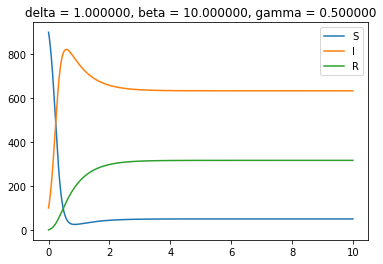

In [224]:
plt.plot(t_train, x_train[:,0], label='S')
plt.plot(t_train, x_train[:,1], label='I')
plt.plot(t_train, x_train[:,2], label='R')
plt.legend()
plt.title("delta = %f, beta = %f, gamma = %f" % (delta, beta, gamma))
# plt.savefig("delta%fbeta%fgamma%f.png" % (delta, beta, gamma), facecolor="white", edgecolor='none', dpi=300)
plt.show()

In [226]:
# Instantiate and fit the SINDy model
model = ps.SINDy(optimizer=ps.optimizers.STLSQ(threshold=0.00001, normalize=True, alpha=0.3))
model.fit(x_train, t=dt, unbias=True)
model.print()

x0' = -0.010 x0 x1 + 0.001 x0 x2 + 0.001 x1 x2 + 0.001 x2^2
x1' = 0.009 x0 x1 + -0.001 x1 x2
x2' = 0.001 x0 x1 + -0.001 x0 x2 + 0.001 x1^2 + -0.001 x1 x2 + -0.001 x2^2


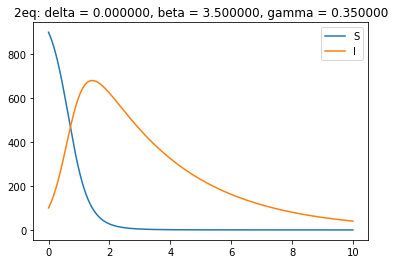

S' = 0.047 1 + 0.004 S + -0.004 S I
I' = 0.175 1 + -0.003 S + -0.351 I + 0.004 S I


In [282]:
# rate R -> S as immunity wears off
delta = 0
# infection rate due to contact btwn I & S
beta = 3.5
# gamma = recovery rate which gives immunity
gamma = 0.35

N = 1000

def sir2(z, t):
    S = z[0]
    I = z[1]
    return [
        delta * (N-S-I) - beta * I * S / N,
        beta * I * S / N - gamma * I
    ]

# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [900, 100]
x_train = odeint(sir2, x0_train, t_train)

plt.plot(t_train, x_train[:,0], label='S')
plt.plot(t_train, x_train[:,1], label='I')
plt.legend()
plt.title("2eq: delta = %f, beta = %f, gamma = %f" % (delta, beta, gamma))
# plt.savefig("2eqdelta%fbeta%fgamma%f.png" % (delta, beta, gamma), facecolor="white", edgecolor='none', dpi=300)
plt.show()

input_features = ['S', 'I']
# Instantiate and fit the SINDy model
model = ps.SINDy(optimizer=ps.optimizers.STLSQ(threshold=0.001), feature_names=input_features)
# model = ps.SINDy(optimizer=ps.optimizers.ConstrainedSR3(threshold=0.001), feature_names=input_features)
noise_level = 0.1
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)
model.fit(x_train_noisy, t=dt, unbias=True)
model.print()

In [284]:
diffs = [
    ('PySINDy Finite Difference', ps.FiniteDifference()),
    ('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=1)),
    ('Smoothed Finite Difference', ps.SmoothedFiniteDifference()),
    ('Savitzky Golay', ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)),
    ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2)),
    ('Trend Filtered', ps.SINDyDerivative(kind='trend_filtered', order=0, alpha=1e-2)),
    ('Spectral', ps.SINDyDerivative(kind='spectral')),
]

equations_clean = {}
equations_noisy = {}
coefficients_clean = {}
coefficients_noisy = {}


noise_level = 0.01

threshold = 0.001
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt,
        feature_names=input_features
    )

    model.fit(x_train)
    equations_clean[name] = model.equations()
    coefficients_clean[name] = model.coefficients()

    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()
    coefficients_noisy[name] = model.coefficients()

print_equations(equations_clean, equations_noisy)

KeyboardInterrupt: 